In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt

# Import custom module for Gaussian particles
sys.path.insert(1, '../1DGaussianTectonics')
from GaussianParticles import GaussParticles
from ParticleSimulator import ParticleSimulator
from HelperFunctions import *
from Forces import ConvergenceForce 

# Used to automatically reload custom modules (for when I'm changing them all the time)
%load_ext autoreload
%autoreload 2

# Goal

We clearly need to improve the spawning and despawning of particles in our main code such that it more closely resembles actual plate tectonic activity. Additionally, we also can benefit from keeping track of additional plate properties such as plate density and crust thickness to further improve our simulations. This notebook is used to explore and experiment various methods for implementing these additional features. Doing so in 1 dimension will make it easier to experiment and visualize what is actually going on.

Some of the code from our previous notebook has been used to create the *1DGaussianTectonics* module, so that we can import and re-use some of it's functionality.

# Moving Plates

We begin by create a force object for moving tectonic plates. This allows us to combine converging and submerging boundaries in a single 1D simulation. The parameter *plateBounds* specifies the tectonic plate that will be moved by this force.

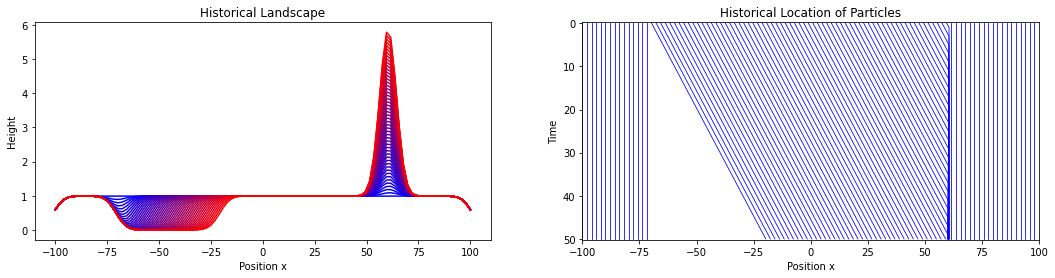

In [3]:
class MovePlate:
    def __init__(self, plateBounds=[-70, 60], speed=1):
        self.plateBounds = plateBounds
        self.speed = speed
    
    def __call__(self, sim):
        x = sim.particles.x
        isOnPlate = (x > self.plateBounds[0]) * (x < self.plateBounds[1])
        sim.particles.x[isOnPlate] += self.speed * sim.dt

# Set up particles as a flat terrane and specify forces to use
plotBounds = [-100, 100]
particles = GaussParticles().initFlat(bounds=plotBounds, numParticles=100, smoothness=2)
forces = [
    MovePlate()
]

# Set up particle simulator and run simulation
sim = ParticleSimulator(particles, forces=forces, dt=1, finalTime=50)
sim.runSimulation()

# Plot resulting landscapes and particle positions
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
sim.particles.xEval =  np.linspace(plotBounds[0], plotBounds[1], 100)
ax[0] = sim.getHistoricLandscapePlot(ax[0])
ax[1] = sim.getHistoricalParticlePositionPlot(ax[1])
plt.show()

# Extending our Particles Class

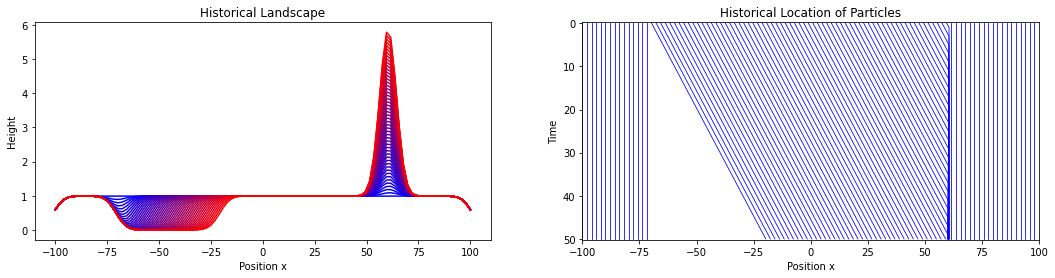

In [4]:
class GaussParticles2(GaussParticles):
    def __init__(
                    # Parameters defined in previous code
                    self, height=1, numParticles=100, bounds=[0, 1], smoothness=2,

                    # Newly defined parameters
                    density=1, thickness=1
    ):

        # Initiate this with a flat terrain
        self.initFlat(height=height, numParticles=numParticles, bounds=bounds, smoothness=smoothness)

        # Introduce some physical properties to the particles
        self.density = density * np.ones(self.x.shape[0])
        self.thickness = thickness * np.ones(self.x.shape[0])
        
        


# Set up particles as a flat terrane and specify forces to use
plotBounds = [-100, 100]
particles = GaussParticles2(bounds=plotBounds, numParticles=100, smoothness=2)
forces = [
    MovePlate()
]

# Set up particle simulator and run simulation
sim = ParticleSimulator(particles, forces=forces, dt=1, finalTime=50)
sim.runSimulation()

# Plot resulting landscapes and particle positions
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
sim.particles.xEval =  np.linspace(plotBounds[0], plotBounds[1], 100)
ax[0] = sim.getHistoricLandscapePlot(ax[0])
ax[1] = sim.getHistoricalParticlePositionPlot(ax[1])
plt.show()

# Modifying Standard Deviations

As of now, we have been keeping all standard deviations of particles to a constant. Since modifying the standard deviations does not change the area under a gaussian particle, we can freely change it without affecting the total volume of the landscape. It is therefore worth experimenting how it affects our results.

In the code bellow, we chose some particles within some given bounds, and multiply their standard deviation by some multiple. This has the effect of moving distributing mass over a further distance and creates a crator like terrain when applied to an otherwise flat terrain.

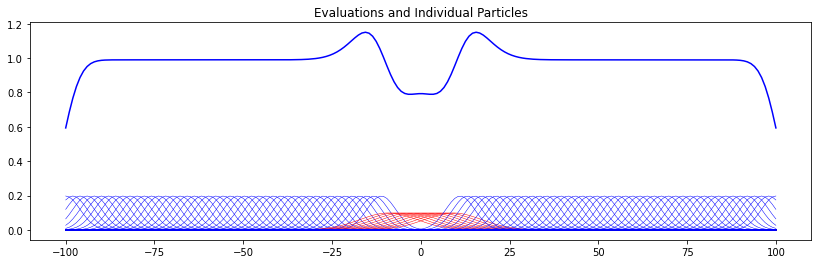

In [99]:
class ModifySTD:
    def __init__(self, bound=[-10, 10], multiple=2):
        self.bound = bound
        self.multiple = multiple

    def __call__(self, sim):
        x = sim.particles.x
        std = sim.particles.std
        isInBound = (x > self.bound[0]) * (x < self.bound[1])
        sim.particles.std[isInBound] = std[isInBound] * self.multiple
        

# Set up particles as a flat terrane and specify forces to use
plotBounds = [-100, 100]
particles = GaussParticles2(bounds=plotBounds, numParticles=100, smoothness=2)
initiators = [
    ModifySTD()
]

# Set up particle simulator and run simulation
sim = ParticleSimulator(particles, dt=1, finalTime=5, initiators=initiators)

# Plot resulting landscapes and particle positions
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
sim.particles.xEval =  np.linspace(plotBounds[0], plotBounds[1], 200)
ax = particles.plotAllParticles(ax, scalars=particles.std)
plt.show()

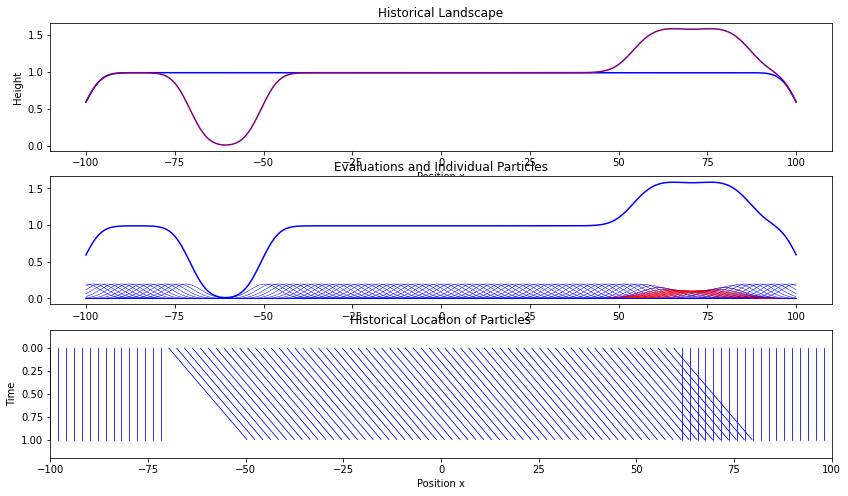

In [194]:
class MeltMountains:
    def __init__(self, thresholdHeight=1.0, multiple=2):
        self.thresholdHeight = thresholdHeight
        self.multiple = multiple

    def __call__(self, sim):
        x = sim.particles.x
        y = sim.particles.evaluate(xEval=x)
        defaultSTD = sim.particles.smoothness * sim.particles.initSpacing
        
        meltThis = (y > self.thresholdHeight)
        newSTD = defaultSTD + 4 * (y - self.thresholdHeight) ** 2
        sim.particles.std[meltThis] = newSTD[meltThis]
        #sim.particles.std = 2 * y ** 2

# Set up particles as a flat terrane and specify forces to use
plotBounds = [-100, 100]
particles = GaussParticles2(bounds=plotBounds, numParticles=100, smoothness=2)
MM = MeltMountains(multiple=2)
forces = [
    MovePlate(speed=20), 
    MeltMountains()
]

# Set up particle simulator and run simulation
sim = ParticleSimulator(particles, forces=forces, dt=1, finalTime=1)
sim.runSimulation()


# Plot resulting landscapes and particle positions
fig, ax = plt.subplots(3, 1, figsize=(14, 8))
sim.particles.xEval =  np.linspace(plotBounds[0], plotBounds[1], 400)
ax[0] = sim.getHistoricLandscapePlot(ax[0])
ax[1] = particles.plotAllParticles(ax[1], scalars=particles.std)
ax[2] = sim.getHistoricalParticlePositionPlot(ax[2]) 
plt.show()

c:\Users\ES11\Desktop\GeoscienceWork\20220614GaussisanParticles\Notebooks\../1DGaussianTectonics\GaussianParticles.py:55: RuntimeWarning: invalid value encountered in true_divide
  


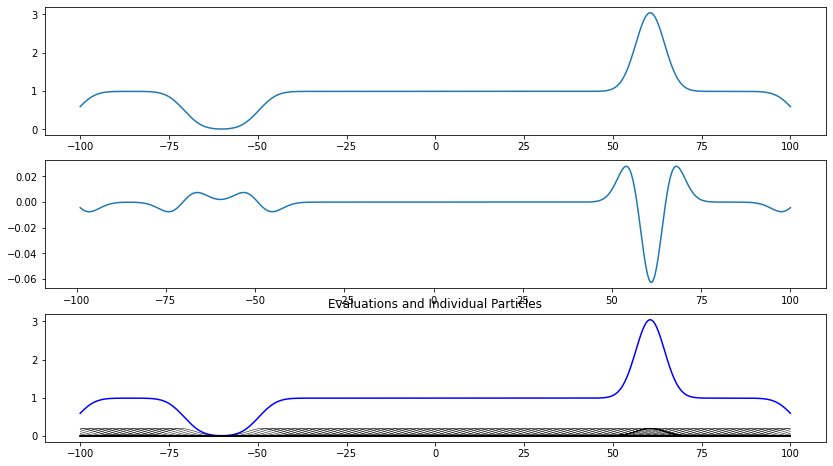

In [100]:
class MeltMountains:
    def __init__(self, thresholdHeight=1.0, multiple=2):
        self.thresholdHeight = thresholdHeight
        self.multiple = multiple

    def __call__(self, sim):
        x = sim.particles.x
        y = sim.particles.evaluate(xEval=x)
        defaultSTD = sim.particles.smoothness * sim.particles.initSpacing
        std = sim.particles.std
        meltThis = (y > self.thresholdHeight)
        
        sim.particles.std[meltThis] = defaultSTD * y[meltThis] ** 1.5
        #sim.particles.std = 2 * y ** 2

# Set up particles as a flat terrane and specify forces to use
plotBounds = [-100, 100]
particles = GaussParticles2(bounds=plotBounds, numParticles=100, smoothness=2)
MM = MeltMountains(multiple=2)
forces = [MovePlate()]

# Set up particle simulator and run simulation
sim = ParticleSimulator(particles, forces=forces, dt=1, finalTime=20)
sim.runSimulation()


# Plot resulting landscapes and particle positions
fig, ax = plt.subplots(3, 1, figsize=(14, 8))
sim.particles.xEval =  np.linspace(plotBounds[0], plotBounds[1], 400)
ax[0].plot(sim.particles.xEval, sim.particles.evaluate())


x = sim.particles.xEval
y = sim.particles.evaluate()
dy = np.diff(y, 1)
dx = np.diff(x, 1)
dydx = dy / dx

dy2 = np.diff(dy, 1)
dx2 = np.diff(x[1:], 1)
dydx2 = dy2 / dx2

ax[1].plot(x[2:], dydx2)
ax[2] = particles.plotAllParticles(ax[2], scalars=particles.std)


plt.show()

c:\Users\ES11\Desktop\GeoscienceWork\20220614GaussisanParticles\Notebooks\../1DGaussianTectonics\GaussianParticles.py:55: RuntimeWarning: invalid value encountered in true_divide
  


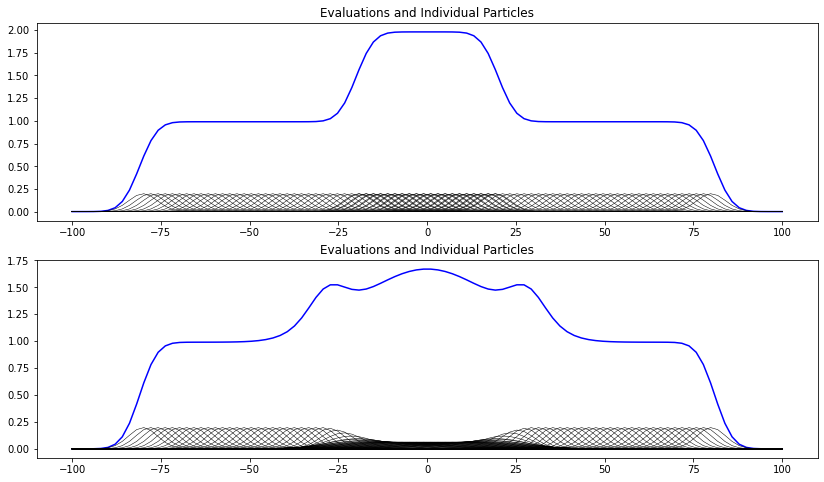

In [38]:
class InitConverged:
    def __init__(self, distMoved=5):
        self.distMoved = distMoved

    def __call__(self, sim):
        x = sim.particles.x
        moveLeftOrRight = 2 * (x < 0) - 1
        sim.particles.x += moveLeftOrRight * self.distMoved

# class MeltMountains:
#     def __init__(self, thresholdHeight=1.1, multiple=2):
#         self.thresholdHeight = thresholdHeight
#         self.multiple = multiple

#     def __call__(self, sim):
#         x = sim.particles.x
#         y = sim.particles.evaluate(xEval=x)
#         std = sim.particles.std
#         meltThis = (y > self.thresholdHeight)
#         sim.particles.std[meltThis] = std[meltThis] * self.multiple * (y[meltThis] - self.thresholdHeight)

class MeltMountains:
    def __init__(self, thresholdHeight=1.0, multiple=2):
        self.thresholdHeight = thresholdHeight
        self.multiple = multiple

    def __call__(self, sim):
        x = sim.particles.x
        y = sim.particles.evaluate(xEval=x)
        defaultSTD = sim.particles.smoothness * sim.particles.initSpacing
        std = sim.particles.std
        meltThis = (y > self.thresholdHeight)
        
        sim.particles.std[meltThis] = defaultSTD * y[meltThis] ** 1.7
        #sim.particles.std = 2 * y ** 2

convergeAmount = 20
meltingMultiple = 2
plotBounds = [-100, 100]

# Set up landscape with converged boundaries
particles = GaussParticles2(bounds=plotBounds, numParticles=100, smoothness=2)
initiators = [InitConverged(distMoved=convergeAmount)]
sim = ParticleSimulator(particles, dt=1, finalTime=5, initiators=initiators)

# Set up particles as a flat terrane and specify forces to use
particles2 = GaussParticles2(bounds=plotBounds, numParticles=100, smoothness=2)
initiators = [InitConverged(distMoved=convergeAmount), 
              MeltMountains(multiple=meltingMultiple)]
sim2 = ParticleSimulator(particles2, dt=1, finalTime=5, initiators=initiators)

# Plot resulting landscapes and particle positions
fig, ax = plt.subplots(2, 1, figsize=(14, 8))
sim.particles.xEval =  np.linspace(plotBounds[0], plotBounds[1], 100)
ax[0] = particles.plotAllParticles(ax[0], scalars=particles.std)

sim2.particles.xEval =  np.linspace(plotBounds[0], plotBounds[1], 100)
ax[1] = particles2.plotAllParticles(ax[1], scalars=particles.std)
plt.show()

In [195]:
print(50.4798 * 23)


1161.0354


In [ ]:
# Set path of main directory
from pathlib import Path
import sys

#mainDir = Path(".").parent.absolute().parent.absolute()
sys.path.insert(1, '../1DGaussianTectonics')

#import importlib
#importlib.import_module('../1DGaussianTectonics/GaussianParticles.py', package='../1DGaussianTectonics/GaussianParticles.py')
#importlib.import_module(str(mainDir) + '/1DGaussianTectonics/Forces.py')

#from ..1DGaussianTectonics.GaussianParticles import GaussianParticles